In [1]:
import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=0, F1=3 / 2, F=2
    ),
    transitions.MicrowaveTransition(
        J_ground=0,
        J_excited=1,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
]

polarizations = [
    [couplings.polarization_Z],
    [couplings.polarization_X, couplings.polarization_Y],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [4]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)
v_to_Γ_μ = 0

odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    PZ0=1,
    # J=0 -> J=1 microwaves
    Ω1=1 * hamiltonian.Γ,
    δ1=f"vx*{v_to_Γ_μ}",
    P1="sin(ω1*t + φ1)",
    PX1="P1>0",
    PY1="P1<=0",
    ω1=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)

In [5]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=states.QuantumSelector(J=2, electronic=states.ElectronicState.X),
    decay_channels=None,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [6]:
obe_system.H_symbolic

Matrix([
[            1.0*δ0 + 83566.3655548096,                                      0,                                     0,                                    0,                                   0, 0.355490640758943*Ω1*(PX1 + I*PY1),                                  0, 0.355490572050064*Ω1*(-PX1 + I*PY1), -0.611252276306874*Ω1*(PX1 + I*PY1), 0.0485590296082812*Ω1*(-PX1 + I*PY1),  0.609320439843381*Ω1*(PX1 - I*PY1),                                   0,                                     0,                                    0,                    0,                                   0,                0,                0,                        0,          0,                        0,                 0],
[                                    0,             1.0*δ0 + 0.203842163085938,                                     0,                                    0,  0.408249495709697*Ω1*(PX1 - I*PY1),                                  0, 0.432220595056205*Ω1*(PX1 - I*PY1),                  

In [7]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

In [8]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 3/2, F = 2>"
states,
"|X, J = 0>",0.479679
"|X, J = 2>",0.520321


In [9]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

,"|B, J = 1, F₁ = 3/2, F = 2>"
states,
"|X, J = 0, F₁ = 1/2, F = 1>",0.479679
"|X, J = 2, F₁ = 3/2, F = 1>",0.011839
"|X, J = 2, F₁ = 3/2, F = 2>",0.102839
"|X, J = 2, F₁ = 5/2, F = 2>",0.028282
"|X, J = 2, F₁ = 5/2, F = 3>",0.377362


In [10]:
from typing import Sequence, Optional
import numpy.typing as npt
from centrex_tlf.utils.population import thermal_population, J_levels


def generate_thermal_population_states(
    temperature: float,
    QN: Sequence[states.State],
    select: Optional[states.QuantumSelector] = None
) -> npt.NDArray[np.complex_]:
    levels = len(QN)
    ρ = np.zeros([levels, levels], dtype=complex)

    assert isinstance(QN[0], states.State), "no State objects supplies"

    if select is not None:
        j_levels = np.unique(select.J)
    else:
        j_levels = np.unique(
            [
                qn.largest.J
                for qn in QN
                if qn.largest.electronic_state == states.ElectronicState.X
            ]
        )

    # get the relative thermal population fractions of the ground state
    population = dict(
        [(j, p) for j, p in zip(j_levels, thermal_population(j_levels, temperature))]
    )

    # # get quantum numbers of the ground state
    # quantum_numbers = [
    #     (qn.largest.J, qn.largest.F1, qn.largest.F, qn.largest.mF)
    #     for qn in QN
    #     if qn.largest.electronic_state == states.ElectronicState.X
    # ]

    # assert len(np.unique(quantum_numbers, axis=0)) == len(
    #     quantum_numbers
    # ), "duplicate quantum numbers"


    for idx, qn in enumerate(QN):
        if qn.largest.electronic_state is not states.ElectronicState.X:
            continue
        elif qn.largest.F is None:
            ρ[idx, idx] = population[qn.largest.J]
        else:
            ρ[idx, idx] = population[qn.largest.J] / J_levels(qn.largest.J)

    return ρ

## Calculate rabi rates and population density

In [11]:
ρ = generate_thermal_population_states(
    temperature = 6.3,
    QN = obe_system.QN,
)
ρ /= np.trace(ρ)

In [12]:
power = 85e-3  # * 11 / 2  # 11 passes assume zero intensity left after 11 passes
intensity = power / (25.4e-3 * 25.4e-3)
rabi = utils.rabi.intensity_to_rabi(
    intensity, obe_system.couplings[0].main_coupling, D=2.6675506e-30
).real

rabi_microwave_01 = utils.rabi.power_to_rabi_gaussian_beam_microwave(
    power=200e-3,
    coupling=obe_system.couplings[1].main_coupling,
    sigma_x=25.4e-3,
    sigma_y=25.4e-3,
).real

## J01 microwave on

In [13]:
odepars.Ωl0 = rabi
odepars.Ω1 = rabi_microwave_01

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)

In [14]:
results = lindblad_julia.do_simulation_single(problem, config=config)

In [15]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

In [16]:
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)


In [17]:
import copy
res = copy.deepcopy(results)

res.y[indices_J1[0],:] = res.y[indices_J1].mean(axis = 0)
res.y = np.delete(res.y, obj = indices_J1[1:], axis = 0)

0.81 photons


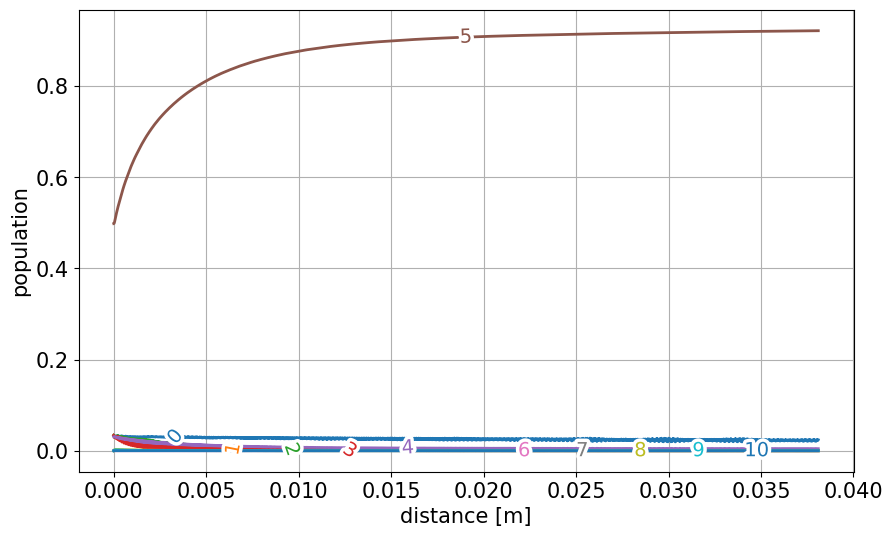

In [18]:
labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(res.t * odepars.vz, res.y.T, lw=2, label = np.arange(len(res.y)))
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize = 14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

0.81 photons


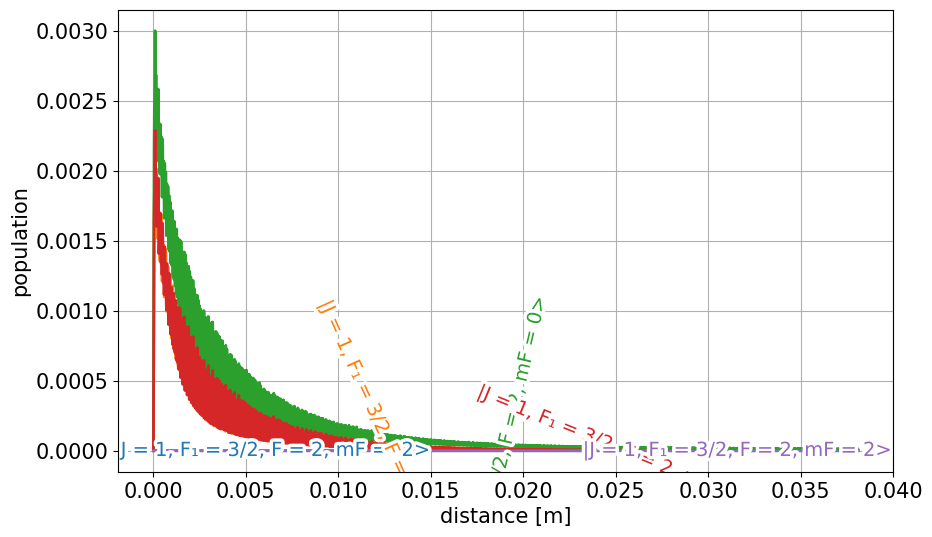

In [20]:
labels = np.array(
    [
        f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}"
        for qn in obe_system.QN
    ]
)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    results.t * odepars.vz,
    results.y[indices_excited].T,
    lw=2,
    label=labels[indices_excited],
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

## J01 microwave off

In [21]:
odepars.Ωl0 = rabi
odepars.Ω1 = 0

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)

In [22]:
results = lindblad_julia.do_simulation_single(problem, config=config)

In [23]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

In [24]:
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

In [25]:
import copy

res = copy.deepcopy(results)

res.y[indices_J1[0], :] = res.y[indices_J1].mean(axis=0)
res.y = np.delete(res.y, obj=indices_J1[1:], axis=0)

0.20 photons


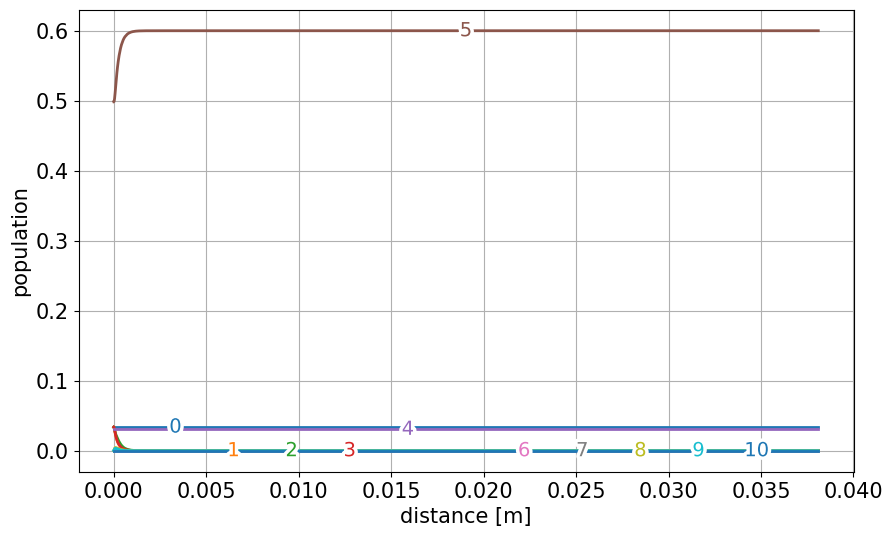

In [26]:
labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(res.t * odepars.vz, res.y.T, lw=2, label=np.arange(len(res.y)))
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

0.20 photons


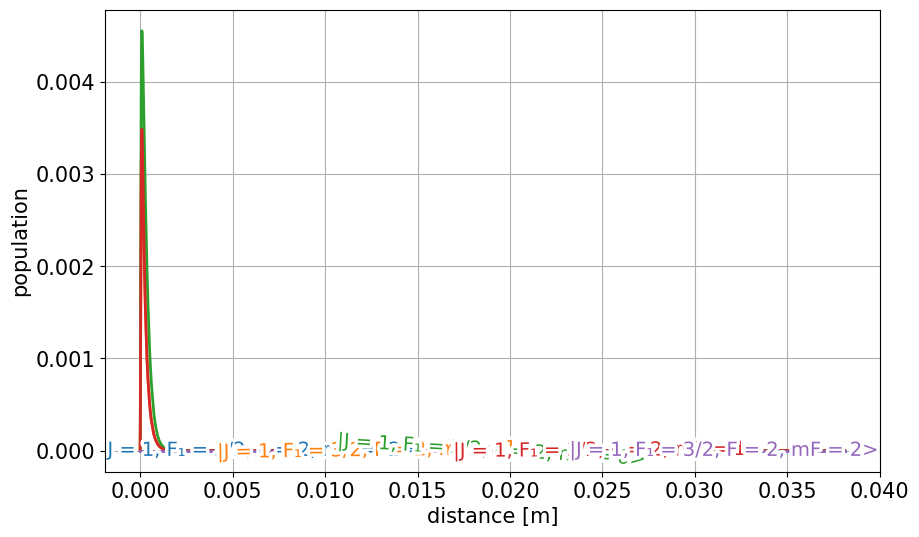

In [27]:
labels = np.array(
    [
        f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}"
        for qn in obe_system.QN
    ]
)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    results.t * odepars.vz,
    results.y[indices_excited].T,
    lw=2,
    label=labels[indices_excited],
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

## Temperature Scan

In [37]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

res = []
for T in tqdm.tqdm(np.linspace(4,18,11)):
    ρ = generate_thermal_population_states(
        temperature = T,
        QN = obe_system.QN,
    )
    ρ /= np.trace(ρ)

    res_toggle = []
    for Ωmu in [0, rabi_microwave_01]:
        odepars.Ωl0 = rabi
        odepars.Ω1 = Ωmu

        problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz))
        config = lindblad_julia.OBEProblemConfig(saveat=5e-7, abstol=1e-8, reltol=1e-5)

        results = lindblad_julia.do_simulation_single(problem, config=config)

        nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ

        res_toggle.append(nphotons)

    res.append((T, res_toggle[1]/res_toggle[0]))



  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:27<00:00,  2.54s/it]


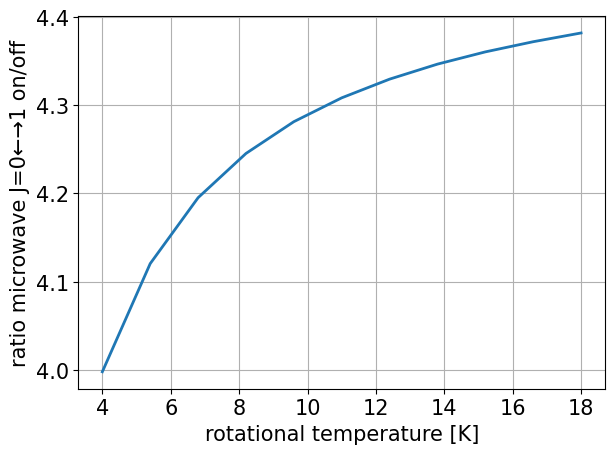

In [38]:
T, ratio = list(zip(*res))

fig,ax=plt.subplots()

ax.plot(T, ratio, lw = 2)
ax.set_xlabel("rotational temperature [K]")
ax.set_ylabel("ratio microwave J=0←→1 on/off")
fig.tight_layout()
ax.grid(True)
